In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

PATH_PROJECT = "/home/yoshraf/projects/master-analysis-inequality-mobility/"

# Reading data
X_train = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/X_train.parquet")
X_test = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/X_test.parquet")
y_train = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/y_train.parquet")
y_test = pd.read_parquet(f"{PATH_PROJECT}data/discrete_choice/y_test.parquet")

# Show all columns
pd.set_option('display.max_columns', None)

### Descovering

In [2]:
X_train.head()

,,,,,Idade,Total de viagens da pessoa,Hora Saída,loc_origem_count_parada,loc_origem_count_ilum_std,loc_origem_dist_metro,loc_origem_dist_trem,loc_origem_dist_term,loc_origem_dist_ciclo,loc_origem_ACC_TI_A_E_60M,loc_origem_ACC_TI_A_L_TP_,loc_destino_count_parada,loc_destino_count_ilum_std,loc_destino_dist_metro,loc_destino_dist_trem,loc_destino_dist_term,loc_destino_dist_ciclo,loc_destino_ACC_TI_A_E_60M,loc_destino_ACC_TI_A_L_TP_,per Quantidade de automóveis,per Quantidade de motocicletas,per Quantidade de bicicletas,per Renda familiar mensal,dist_od,diff_cota_od,Gênero_Masculino
Identifica pessoa,Zona de domicílio,Data da entrevista,Coordenada X domicílio,Coordenada Y domicílio,,,,,,,,,,,,,,,,,,,,,,,,,,
00282196101,28.0,23092018,331708.0,7393299.0,57.0,2.0,14.333333,1,105,1217.800987,3547.932804,3290.091381,262.058333,4271617.0,416.0,1,105,522.681713,3338.014663,1731.309643,407.683457,4428729.0,390.0,0.000000,0.0,0.00,695.330805,1560.489987,-24.773333,1.0
03200074102,320.0,16042018,324560.0,7387434.0,50.0,2.0,15.000000,6,98,2610.339533,1097.721910,3911.528738,870.573780,3808520.0,66.0,6,98,3145.783687,1676.729890,3548.631386,123.953564,3433596.0,50.0,0.333333,0.0,0.00,1259.396241,989.388700,-28.240000,0.0
01370004101,137.0,02112017,330750.0,7401259.0,50.0,2.0,22.000000,14,99,1319.401421,1718.357084,3352.467244,345.777600,4055568.0,65.0,14,99,3636.523593,3989.968736,807.919150,197.892501,3509084.0,35.0,0.500000,0.0,0.00,1750.000000,10257.562527,31.646153,1.0
01411826101,141.0,02092018,331203.0,7403277.0,52.0,4.0,14.000000,41,158,1420.717482,3512.424292,2123.334762,276.671652,3436001.0,57.0,41,158,266.701255,3462.442456,1252.500086,177.213780,3522456.0,141.0,1.000000,0.0,1.00,3611.407337,1276.084637,15.873333,0.0
01080003101,108.0,07042018,321845.0,7397275.0,27.0,4.0,8.000000,0,150,6175.429641,817.835089,4448.908189,1431.768721,4128288.0,62.0,0,150,6042.925568,828.213296,4654.169667,1209.999731,4128288.0,62.0,0.000000,0.0,0.25,521.498104,330.006061,2.180000,0.0


In [3]:
X_train.shape

(76598, 26)

In [4]:
y_train["Modo Principal"].value_counts(normalize=True)

A pé                                                   0.301901
Dirigindo automóvel                                    0.243949
Ônibus/micro-ônibus/perua do município de São Paulo    0.164234
Metrô                                                  0.109324
Passageiro de automóvel                                0.082221
Transporte escolar                                     0.034100
Táxi não convencional                                  0.018290
Dirigindo moto                                         0.017141
Trem                                                   0.012637
Bicicleta                                              0.008525
Táxi convencional                                      0.007676
Name: Modo Principal, dtype: float64

### Machine Learning Model

In [5]:
def rf_modeling(X_train, X_test, y_train, y_test, params):
    # Fit and Training model
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    # Predict test and train datasets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Plot Confusion Matrix
    fig, ax = plt.subplots(1, figsize=(12,6))
    plot_confusion_matrix(model, X_test, y_test, ax=ax)
    labels = ["A Pé", "Carro", "Bus", "Uber", "Bike", "Moto", "Metro/Trem"]
    # Classification Report
    print(classification_report(y_test, y_pred_test, target_names=labels))
    print("Main Features:")
    feats = {}
    for feature, importance in zip(X_train.columns, model.feature_importances_):
        feats[feature] = importance * 100
    df_imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'}).sort_values("Importance", ascending=False)
    print(df_imp.head(10))
    return model

def logit_modeling(X_train, X_test, y_train, y_test, params):
    # Fit and Training model
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    # Predict test and train datasets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Plot Confusion Matrix
    fig, ax = plt.subplots(1, figsize=(12,6))
    plot_confusion_matrix(model, X_test, y_test, ax=ax)
    labels = ["A Pé", "Carro", "Bus", "Uber", "Bike", "Moto", "Metro/Trem"]
    # Classification Report
    print(classification_report(y_test, y_pred_test, target_names=labels))
    return model

In [6]:
map_dict ={
    "Passageiro de automóvel": 1,
    "Dirigindo automóvel": 1,
    "Ônibus/micro-ônibus/perua do município de São Paulo": 2,
    "Táxi não convencional": 3,
    "Táxi convencional": 3,
    "Bicicleta": 4,
    "Dirigindo moto": 5,
    "Metrô":6,
    "Trem": 6
}

map_ref ={
        0: "A pé",
        1: "Carro",
        2: "Ônibus",
        3: "Uber",
        4: "Bike",
        5: "Moto",
        6: "Metro/trem"
    }

y_train_new = y_train["Modo Principal"].map(map_dict).fillna(0)
y_test_new = y_test["Modo Principal"].map(map_dict).fillna(0)

              precision    recall  f1-score   support

        A Pé       0.87      0.92      0.89     11035
       Carro       0.72      0.85      0.78     10610
         Bus       0.68      0.56      0.61      5479
        Uber       0.76      0.12      0.20       904
        Bike       0.98      0.15      0.26       295
        Moto       0.86      0.30      0.44       532
  Metro/Trem       0.65      0.62      0.63      3974

    accuracy                           0.76     32829
   macro avg       0.79      0.50      0.55     32829
weighted avg       0.76      0.76      0.75     32829

Main Features:
                              Importance
dist_od                        23.467312
per Quantidade de automóveis    7.711727
Idade                           6.080745
per Renda familiar mensal       5.191472
diff_cota_od                    3.645415
loc_origem_dist_metro           3.572936
loc_destino_dist_metro          3.555166
loc_origem_ACC_TI_A_E_60M       3.008185
loc_destino_ACC_TI_

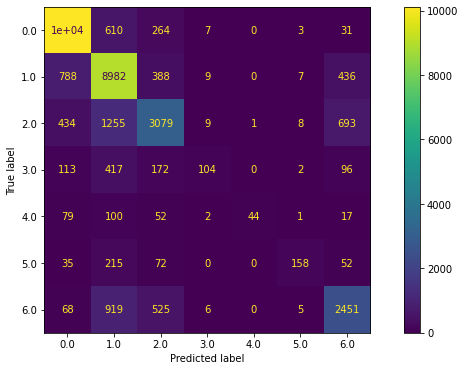

In [7]:
clf_params = {"n_estimators": 1000, "max_depth": 12, "random_state": 0, "min_samples_leaf": 30, "max_features": "auto", "max_samples": .8, "n_jobs": -1}
# clf_rf = rf_modeling(X_train, X_test, y_train_new, y_test_new, clf_params)
clf_rf = rf_modeling(X_train, X_test, y_train_new, y_test_new, {})

In [8]:
clf_logit = logit_modeling(X_train, X_test, y_train_new, y_test_new, {"max_iter": 1000})

KeyboardInterrupt: 

In [9]:
sample = X_train.sample(1000)
# explainer = shap.Explainer(clf_rf)
explainer = shap.TreeExplainer(clf_rf)
shap_values = explainer(sample)

In [9]:
# Expected Values
shap_values.base_values[0]

array([0.33665657, 0.32491188, 0.16477663, 0.02629938, 0.00861276,
       0.01675488, 0.12198791])

# SHAP Feature Importance

In [10]:
sum_all = shap_values[:,:,1]+shap_values[:,:,2]+shap_values[:,:,3]+shap_values[:,:,4]+shap_values[:,:,5]+shap_values[:,:,6]+shap_values[:,:,1]+shap_values[:,:,0]

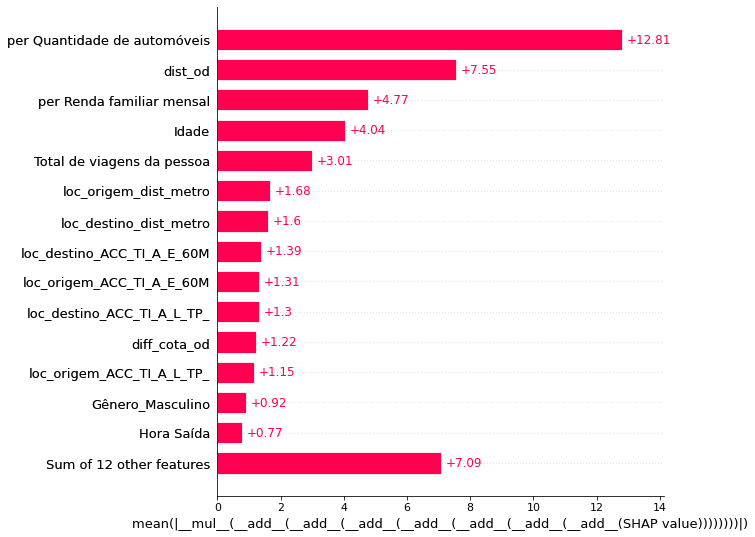

In [11]:
shap.plots.bar(sum_all*100, max_display=15)

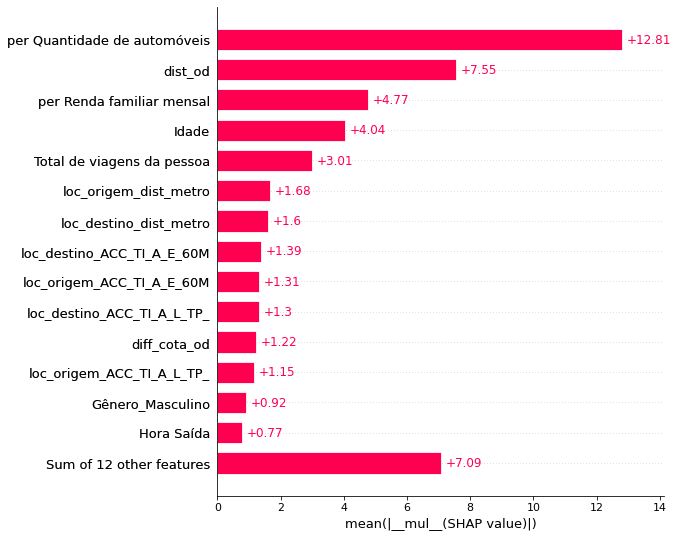

In [12]:
shap.plots.bar(shap_values[:,:,1]*100, max_display=15)

#### Max SHAP Value

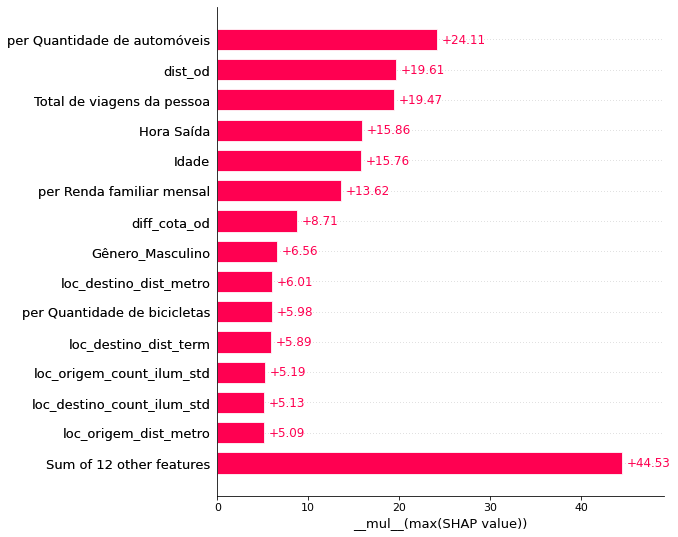

In [13]:
shap.plots.bar(shap_values[:,:,1].max(0)*100, max_display=15, order=shap_values[:,:,1].max(0)*100)

#### Min SHAP Value

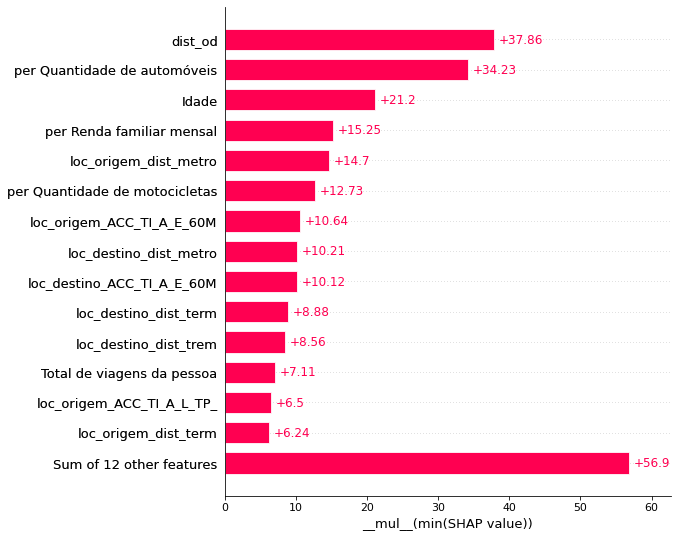

In [14]:
shap.plots.bar(shap_values[:,:,1].min(0)*-100, max_display=15, order=shap_values[:,:,1].min(0)*-100)

### Beeswarm Summarize Plot

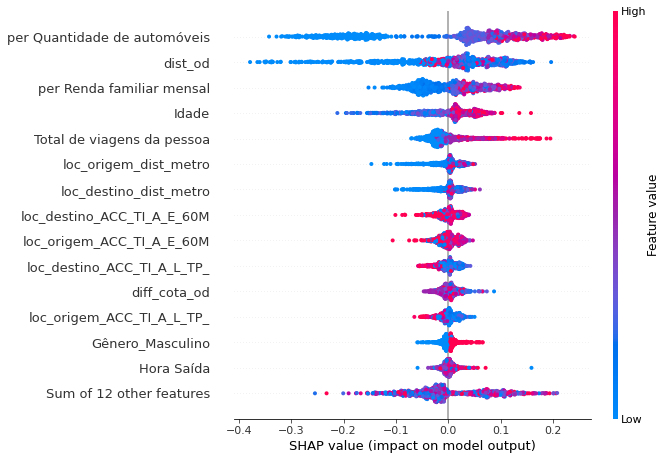

In [15]:
shap.plots.beeswarm(sum_all, max_display=15)

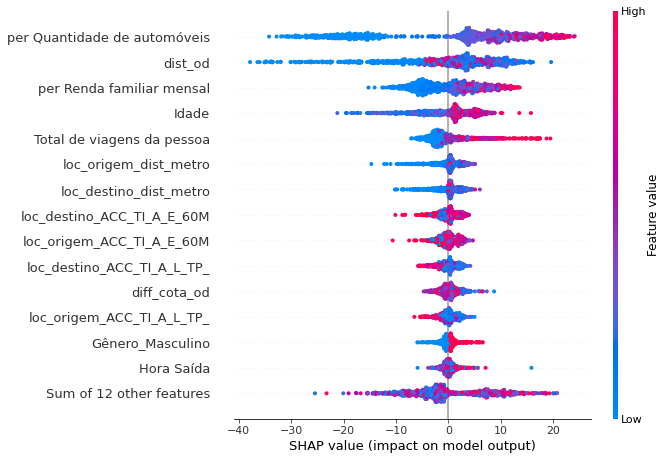

In [16]:
shap.plots.beeswarm(shap_values[:,:,1]*100, max_display=15)

### Understanding Main Features
#### SHAP PDP

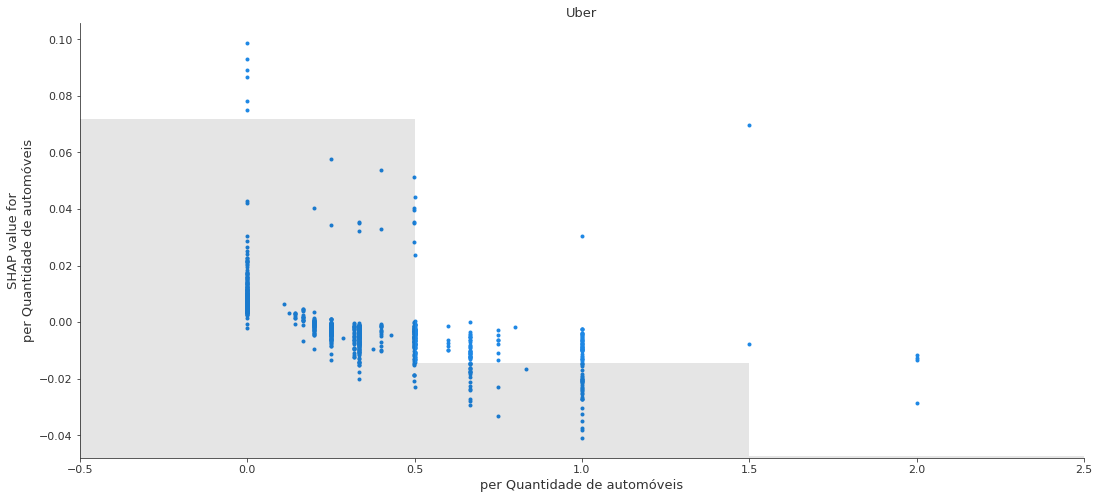

In [17]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 3
shap.plots.scatter(shap_values[:,"per Quantidade de automóveis",modo], ax=ax, title=map_ref[modo])

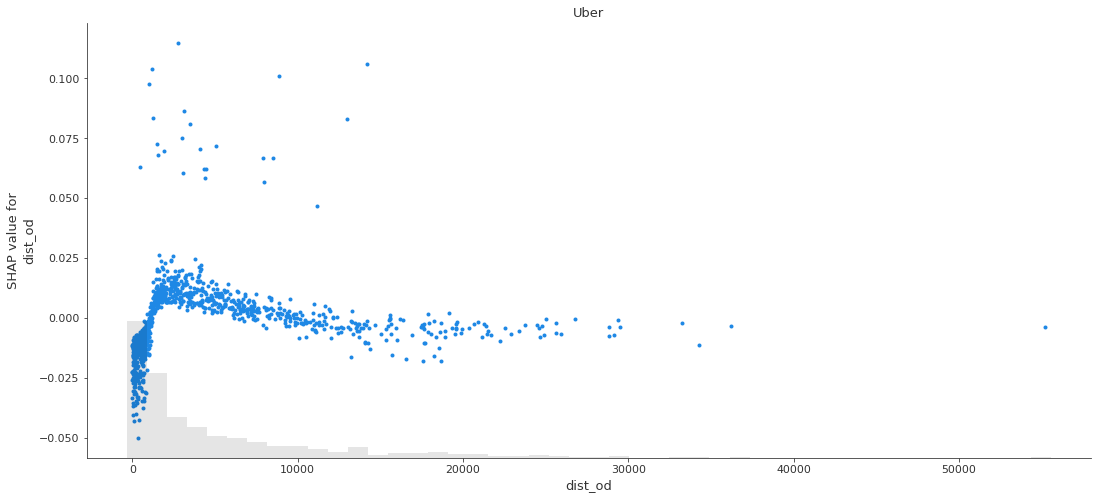

In [18]:
fig, ax = plt.subplots(1, figsize=(18,8))
shap.plots.scatter(shap_values[:,"dist_od",3], ax=ax,  title=map_ref[modo])

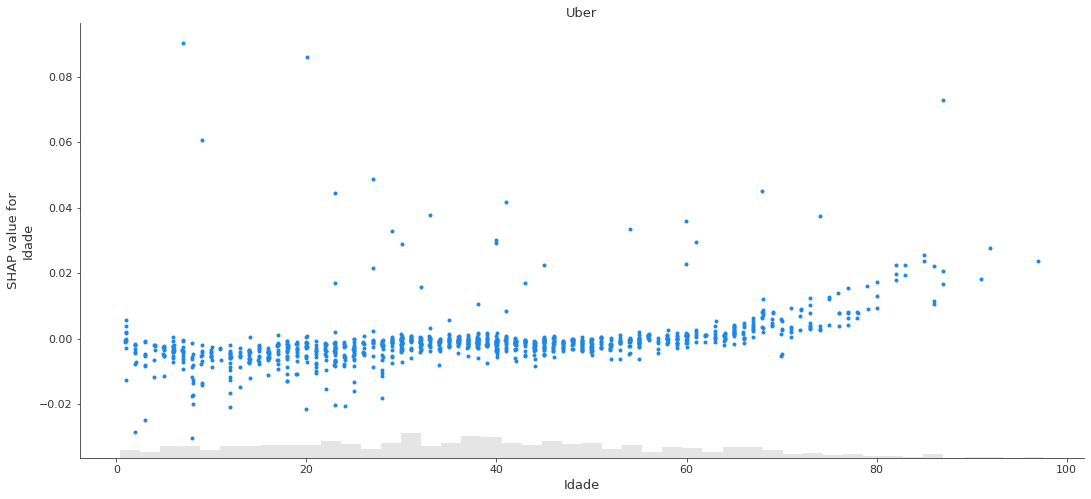

In [19]:
fig, ax = plt.subplots(1, figsize=(18,8))
shap.plots.scatter(shap_values[:,"Idade",3], ax=ax,  title=map_ref[modo])

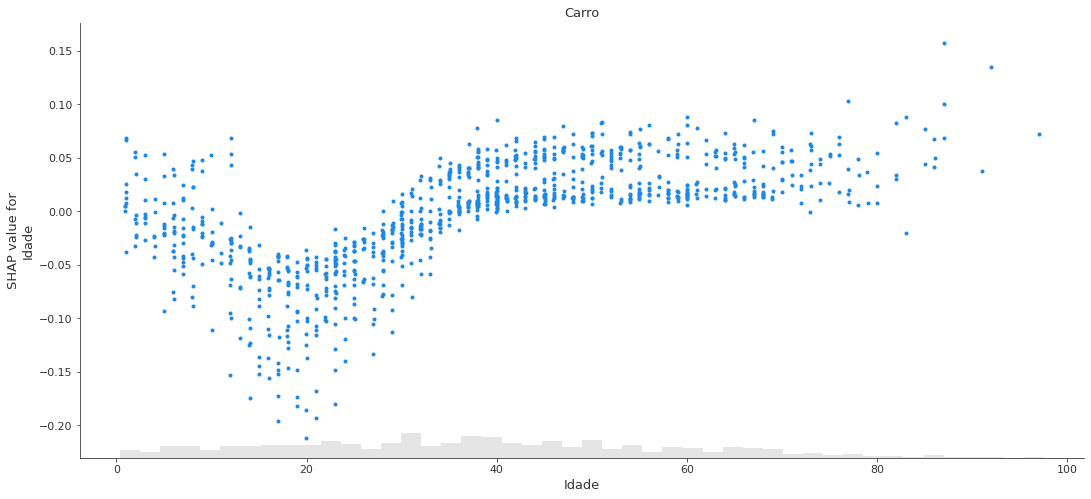

In [20]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 1
shap.plots.scatter(shap_values[:,"Idade",modo], ax=ax,  title=map_ref[modo])

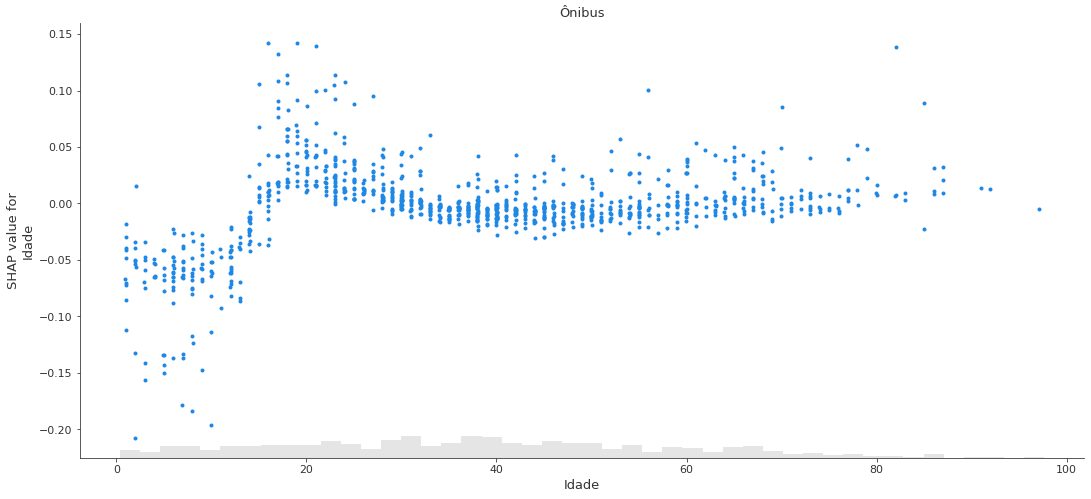

In [21]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 2
shap.plots.scatter(shap_values[:,"Idade",modo], ax=ax,  title=map_ref[modo])

#### Plot for 2 Features

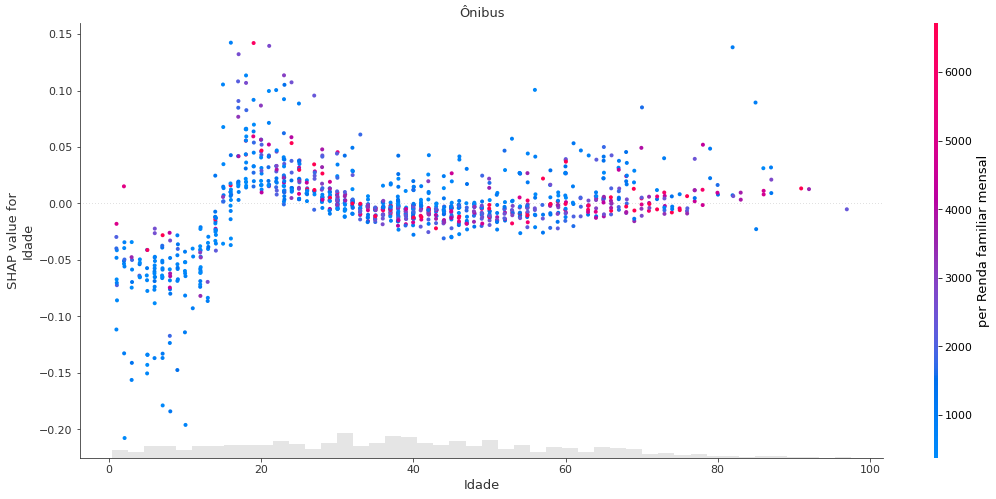

In [22]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 2
shap.plots.scatter(shap_values[:,"Idade",modo], color=shap_values[:,"per Renda familiar mensal",2], ax=ax,  title=map_ref[modo])

#### Categorical Data

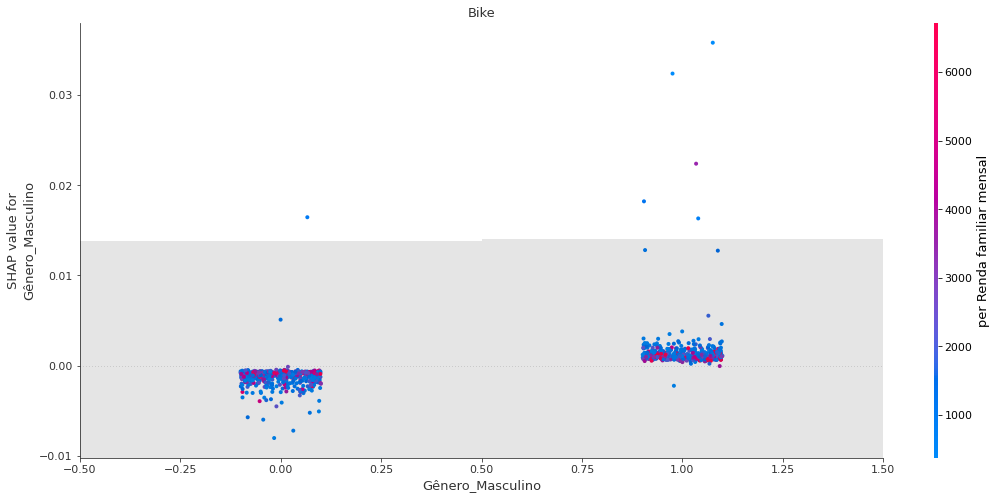

In [23]:
fig, ax = plt.subplots(1, figsize=(18,8))
modo = 4
shap.plots.scatter(shap_values[:,"Gênero_Masculino",modo], color=shap_values[:,"per Renda familiar mensal",modo],  title=map_ref[modo], ax=ax)

### SHAP ICE and PDP

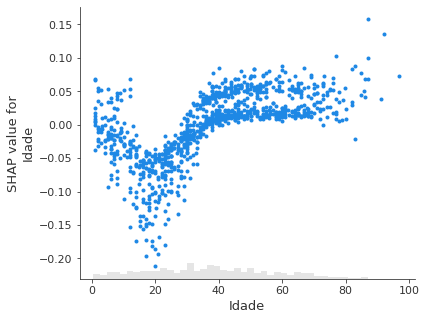

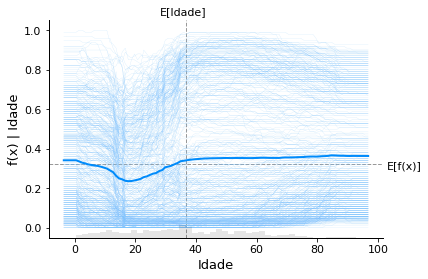

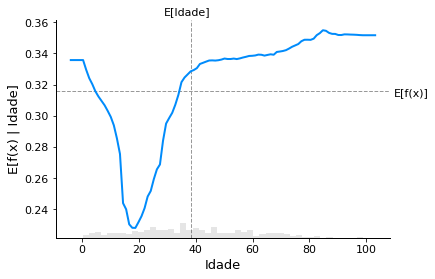

In [24]:
def predict_to_dp(x):
    return clf_rf.predict_proba(x)[:,1]

shap.plots.scatter(shap_values[:,"Idade",1])

shap.partial_dependence_plot(
    "Idade", predict_to_dp, X_train.sample(500), model_expected_value=True,
    feature_expected_value=True, ice=True
)

shap.partial_dependence_plot(
    "Idade", predict_to_dp, X_train.sample(500), model_expected_value=True,
    feature_expected_value=True, ice=False
)

### Correlation Matrix

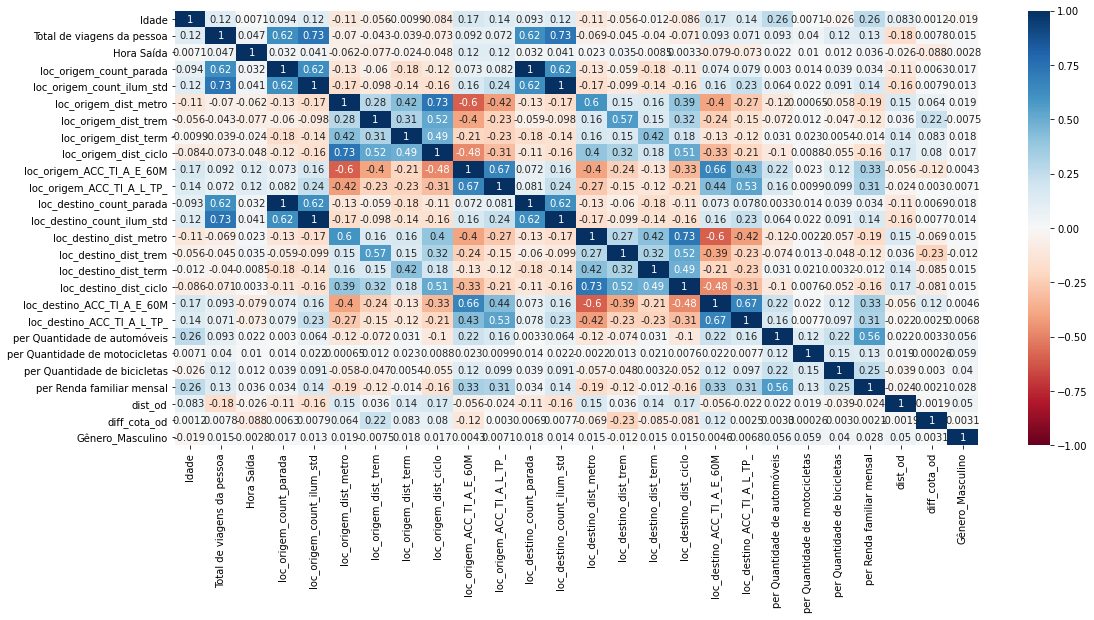

In [25]:
fig, ax = plt.subplots(1, figsize=(18,8))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu', ax=ax)

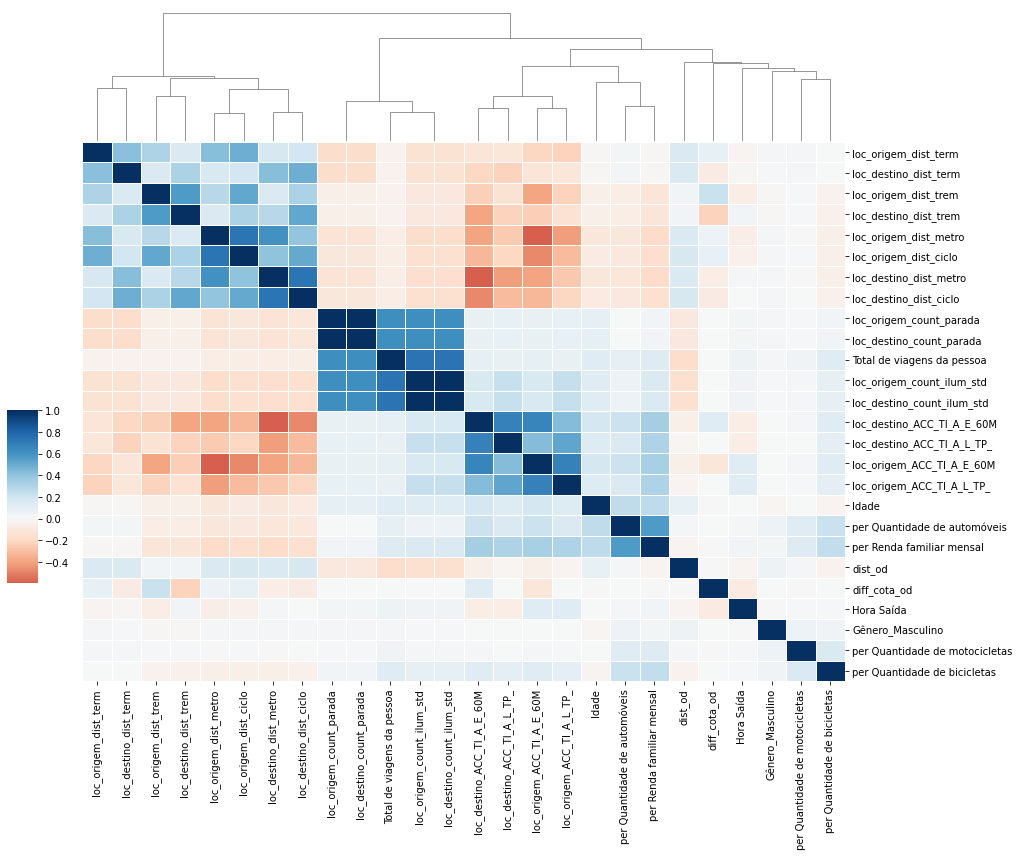

In [26]:
f = .8
g = sns.clustermap(X_train.corr(), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(18*f, 15*f))
g.ax_row_dendrogram.remove()

### SHAP Correlation Matrix | Feature Behavior Correlation

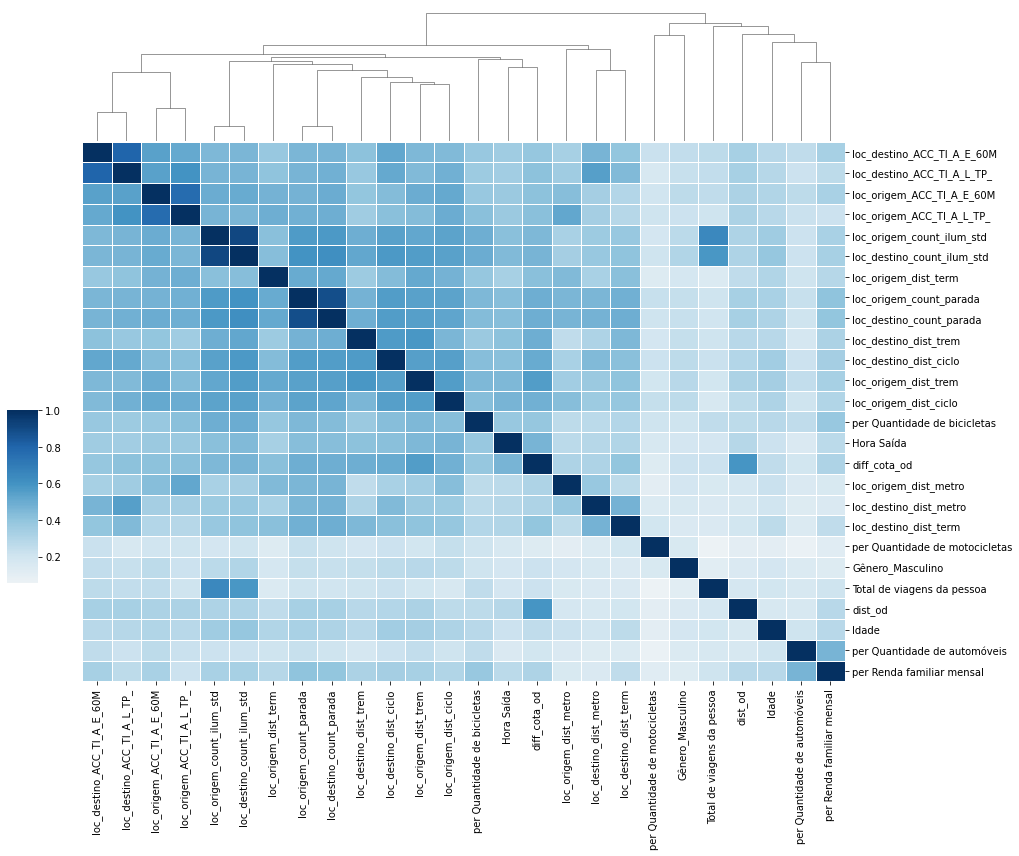

In [28]:
df_shap = pd.DataFrame(shap_values.values[:,:,1], columns=shap_values.feature_names)

f = .8
# Draw the full plot
g = sns.clustermap(df_shap.corr(), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(18*f, 15*f))
g.ax_row_dendrogram.remove()

### SHAP Clustering

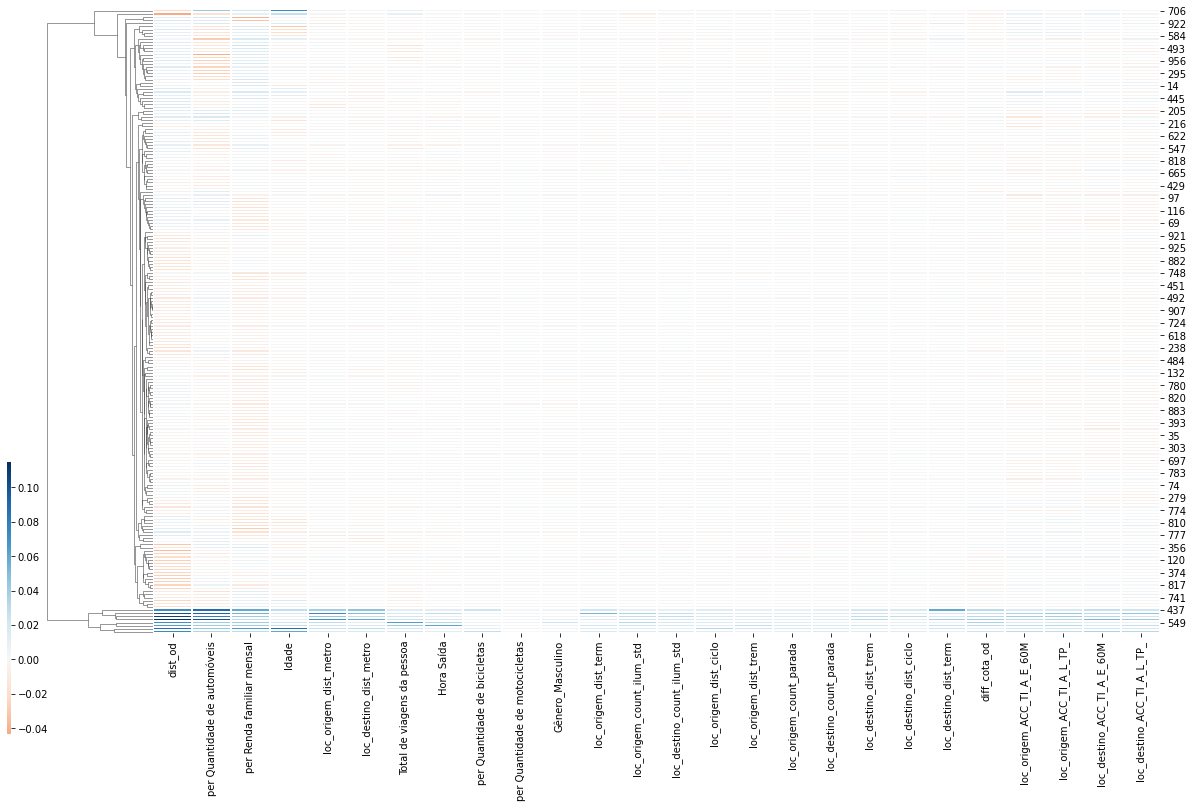

In [29]:
df_shap = pd.DataFrame(shap_values.values[:,:,3], columns=shap_values.feature_names)

f = .9
# Draw the full plot
g = sns.clustermap(df_shap.sample(200), center=0, cmap="RdBu",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-0.02, 0.08, .003, 0.28),
                   linewidths=.05, figsize=(18*f, 15*f))
g.ax_col_dendrogram.remove()

### SHAP Clustering | Heatmap

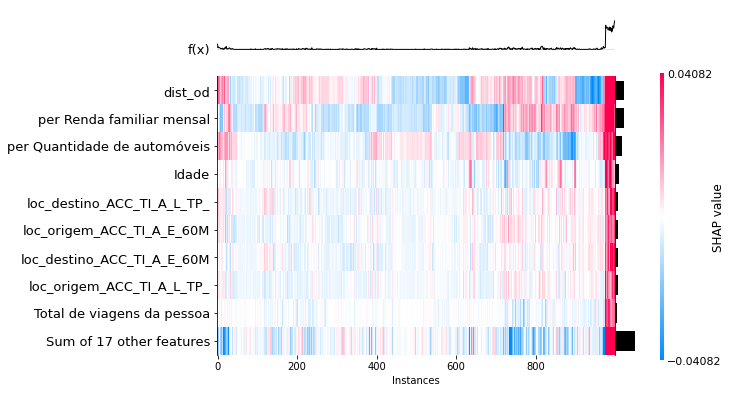

In [30]:
shap.plots.heatmap(shap_values[:,:,3])

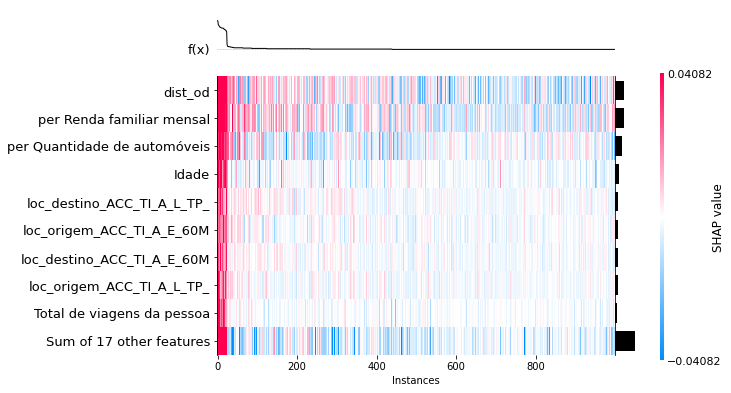

In [31]:
shap.plots.heatmap(shap_values[:,:,3], instance_order=shap_values[:,:,3].sum(1))

### Demographic parity

FixedFormatter should only be used together with FixedLocator


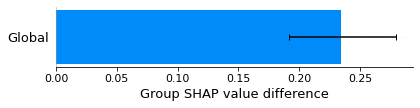

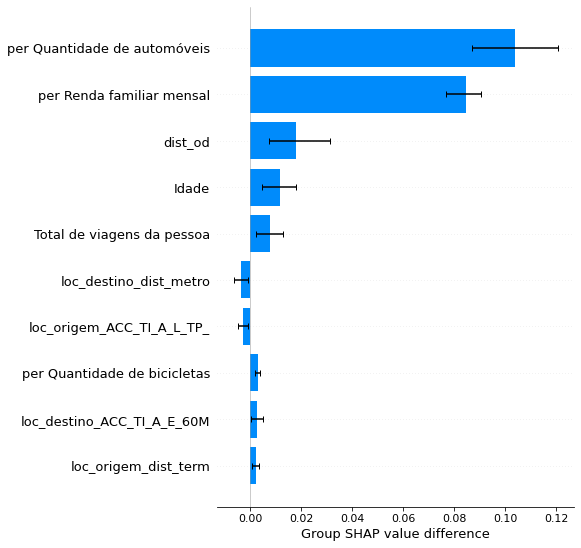

In [32]:
group_A = sample["per Renda familiar mensal"].values >= 3000
shap.group_difference_plot(shap_values[:,:,1].values.sum(1), group_A, ["Global"], max_display=10)
shap.group_difference_plot(shap_values[:,:,1].values, group_A, sample.columns, max_display=10)

In [ ]:
group_A = sample["Gênero_Masculino"].values == 1
shap.group_difference_plot(shap_values[:,:,4].values.sum(1), group_A, ["Global"], max_display=10)
shap.group_difference_plot(shap_values[:,:,4].values, group_A, sample.columns, max_display=10)

### GeoDemographic parity

Index(['NumeroDist', 'NomeDistri', 'Area_ha', 'geometry'], dtype='object')


<AxesSubplot:>

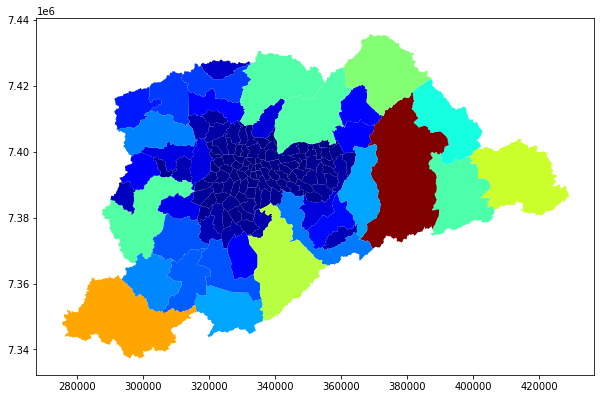

In [36]:
import geopandas as gpd
df_geo = gpd.read_file("/home/yoshraf/projects/mestrado/data/gis/od2017/Distritos_2017_region.shp")
print(df_geo.columns)
df_geo.plot(cmap="jet", column= "Area_ha", figsize=(10,10))

In [37]:
def relevancia(perif, centro, model_idx, map_ref):
    # Georeferênia
    df_sample_geo = gpd.GeoDataFrame(geometry = gpd.points_from_xy(X_train.reset_index()["Coordenada X domicílio"], X_train.reset_index()["Coordenada Y domicílio"]))
    # Seleciona os distristos de interesse
    df_geo_centro = df_geo[df_geo["NomeDistri"].isin(centro)]
    df_geo_perif = df_geo[df_geo["NomeDistri"].isin(perif)]
    # Boolianos se é centro ou periferia do 'X_train'
    bool_centro = gpd.sjoin(df_sample_geo, df_geo_centro, how="left", op='intersects')["index_right"].fillna(0) != 0
    bool_perif = gpd.sjoin(df_sample_geo, df_geo_perif, how="left", op='intersects')["index_right"].fillna(0) != 0
    # Estamos interessados apenas neste dois: Centro e Periferia
    df_final = X_train.reset_index()[bool_centro + bool_perif].set_index(sample.index.names)
    # Calculate shap values for those data
    shap_values = explainer(df_final)
    # Create a GeoDataFrame
    df_sample_geo = gpd.GeoDataFrame(geometry = gpd.points_from_xy(df_final.reset_index()["Coordenada X domicílio"], df_final.reset_index()["Coordenada Y domicílio"]))
    bool_centro_final = gpd.sjoin(df_sample_geo, df_geo_centro, how="left", op='intersects')["index_right"].fillna(0) != 0
    # Plot Group Diff Plot
    for it in model_idx:
        print(map_ref[it])
        print(f"Valor Esperado: {shap_values[:,:,it].base_values[0].round(2)}")
        shap.group_difference_plot(shap_values[:,:,it].values.sum(1), bool_centro_final, ["Global"])
        shap.group_difference_plot(shap_values[:,:,it].values, bool_centro_final, sample.columns, max_display=10)
    

In [ ]:
perif = ["Brasilândia", "Grajaú"]
centro = ["Moema", "Bela Vista"]

relevancia(perif, centro, [1,2,3,4,6], map_ref)

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523



Valor da Feature para cada grupo >> Comportamento do Modelo para este modo de Transporte

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

FixedFormatter should only be used together with FixedLocator


Carro
Valor Esperado: 0.33


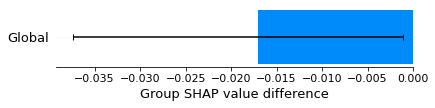

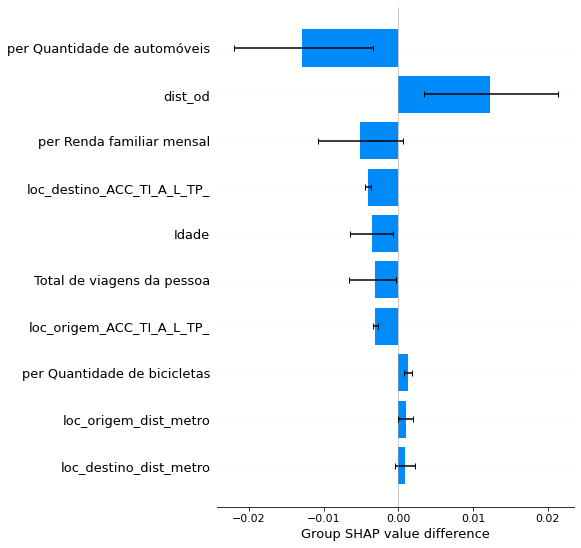

Uber
Valor Esperado: 0.03


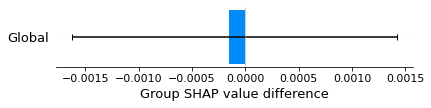

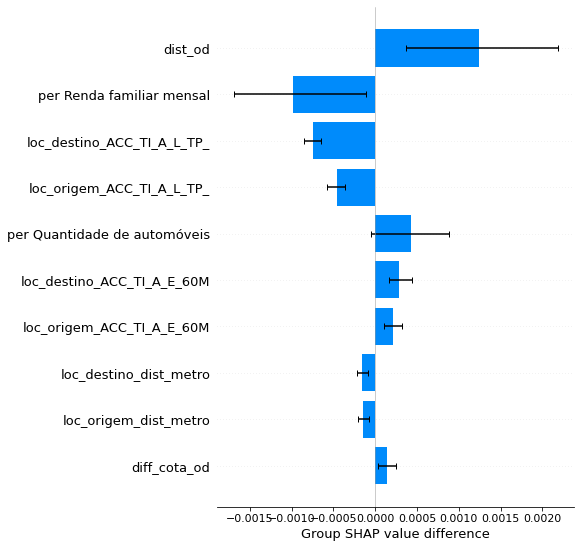

Bike
Valor Esperado: 0.01


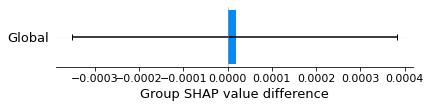

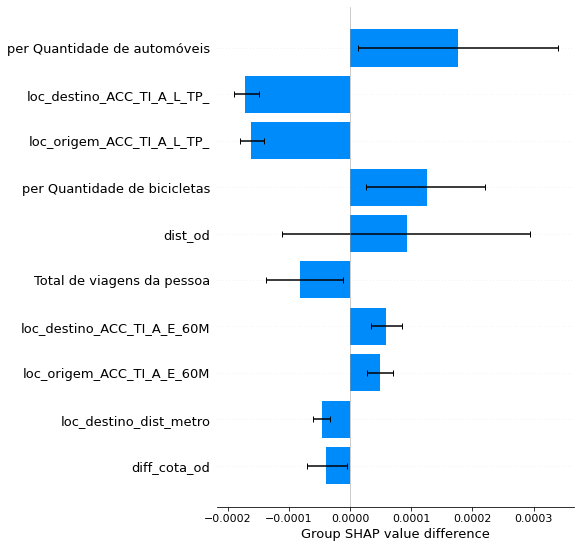

Metro/trem
Valor Esperado: 0.12


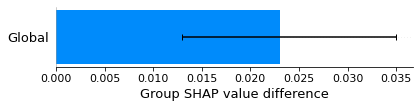

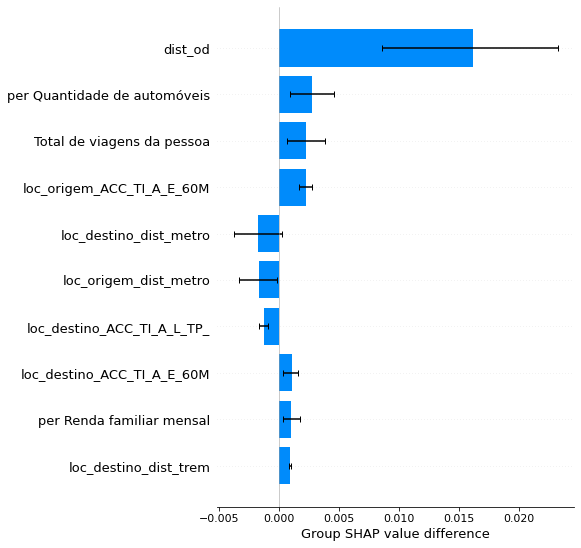

In [82]:
perif = ["Carrão"]
centro = ["Pirituba"]

relevancia(perif, centro, [1,3,4,6], map_ref)

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:22523



Carro
Valor Esperado: 0.33


FixedFormatter should only be used together with FixedLocator


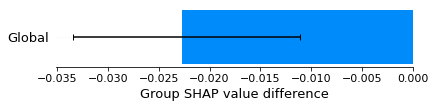

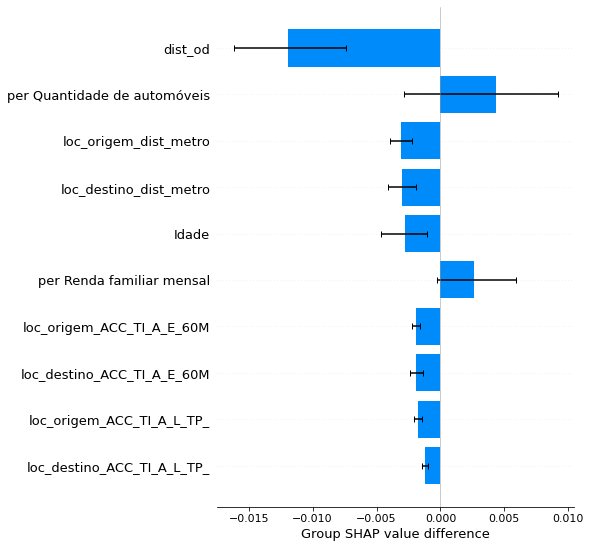

Uber
Valor Esperado: 0.03


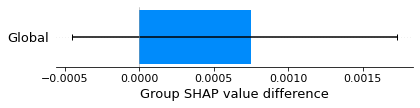

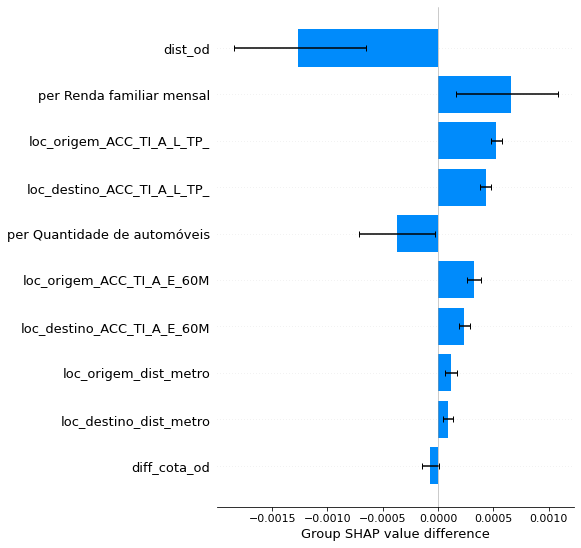

Bike
Valor Esperado: 0.01


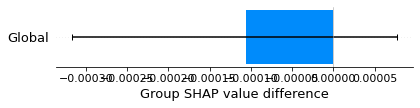

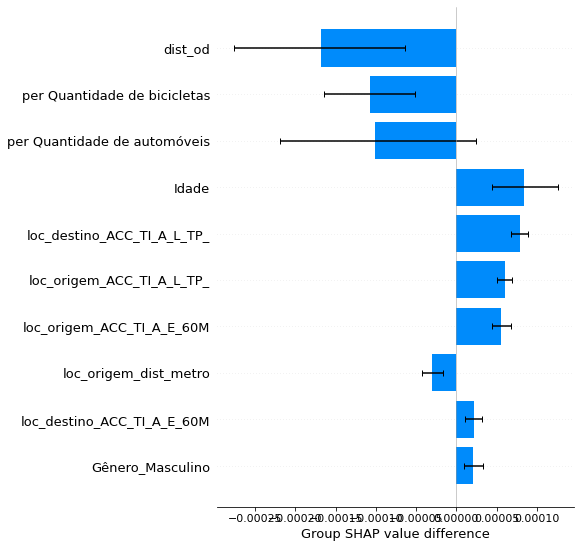

Metro/trem
Valor Esperado: 0.12


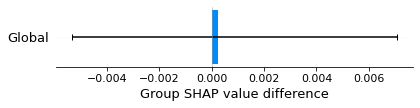

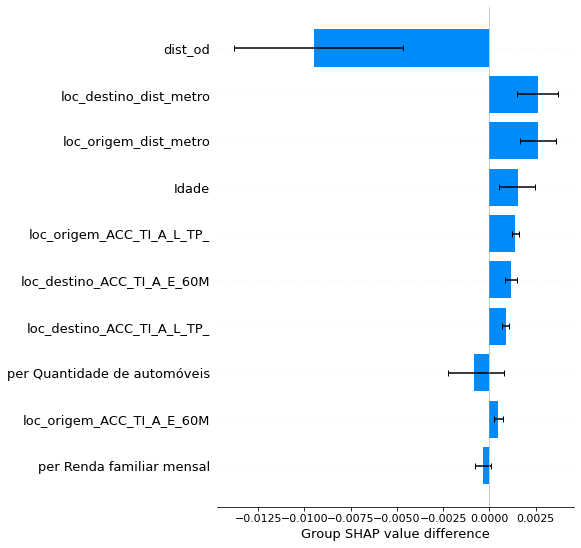

In [83]:
perif = ["Saúde"]
centro = ["Vila Mariana"]

relevancia(perif, centro, [1,3,4,6], map_ref)

### Thank you all!